# Visualisation Features

In [2]:
import os
os.chdir('D:\open_source\pyshbundle')

import pyshbundle
from tqdm import trange
from datetime import datetime

from pyshbundle.new_io import read_jpl, read_csr, read_tn13, read_tn14, extract_C10_11_replcmnt_coeff, cklm2sc_new
from pyshbundle.new_io import extract_C20_replcmnt_coeff, extract_C30_replcmnt_coeff, replace_zonal_coeff, find_date_in_replacemnt_file
from pyshbundle.new_io import read_itsg

import numpy as np
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import xarray as xr

In [3]:
import pyshbundle.reader_replacer_jpl
import pyshbundle.reader_replacer_csr
import pyshbundle.reader_replacer_itsg

from pyshbundle import gshs, plm, sc2cs
from pyshbundle.clm2sc import clm2sc_new
from pyshbundle.clm2cs import clm2cs_new

## Load Data

In [4]:
tn14_path_itsg = 'D:\\open_source\\pyshbundle\pyshbundle\\data\\ITSG_TN_files\\TN-14_C30_C20_SLR_GSFC.txt'
tn_13_path_itsg = 'D:\\open_source\\pyshbundle\\pyshbundle\\data\\ITSG_TN_files\\TN-13_GEOC_CSR_RL06.1.txt'
itsg_folder = 'D:\\open_source\\pyshbundle\\sample_input_data\\ITSG_input'
itsg_file = 'D:\\open_source\\pyshbundle\\sample_input_data\\ITSG_input\\ITSG-Grace2018_n96_2011-05.gfc'

In [5]:
data_itsg_mat= np.ndarray((4753, 6))
header = read_itsg(itsg_file)[0]
data_itsg_mat = read_itsg(itsg_file)[1]
dates_itsg = read_itsg(itsg_file)[2]

In [6]:
scmat_itsg, devscmat_itsg = clm2sc_new(data_itsg_mat, lmax=96, sigma_flag=True)

In [7]:
# Read replacemnt file
data_tn13_itsg = read_tn13(tn_13_path_itsg)
data_tn14_itsg = read_tn14(tn14_path_itsg)

In [8]:
replaced_data_mat = replace_zonal_coeff(data_itsg_mat, 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg, epoch_end=None)

Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
[1.00000000e+00 0.00000000e+00 1.92070086e-12 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.19237304e-10 -1.66149501e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01
Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01


In [9]:
rep_sc, rep_dev = clm2sc_new(replaced_data_mat, lmax=96, sigma_flag=True)

## Computation

# Visualise data

In [12]:
def sc_triplot(scmat: np.ndarray, lmax: int, title: str, vmin, vmax):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    im = ax.imshow(np.ma.log10(abs(scmat)), extent=[-lmax, lmax, lmax, 0], cmap='Spectral_r',vmin=vmin, vmax=vmax)
    ax.grid()
    # plt.colorbar()
    x_vec = np.arange(-lmax, lmax+1, 6)
    y_vec = np.arange(lmax, -2, -6)

    x_st = 0*y_vec

    # vertical line
    ax.plot(x_st, y_vec, "black") 

    plt.xticks(x_vec,)
    plt.yticks(y_vec)
    plt.title(title)
    fig.colorbar(im,)    
    return ax

def cs_sqplot(csmat: np.ndarray, lmax: int, title: str, vmin, vmax):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    im = ax.imshow(np.ma.log10(abs(csmat)), extent=[0, lmax, lmax, 0], cmap='Spectral_r',vmin=vmin, vmax=vmax)
    ax.grid()
    ax.set_aspect('equal')

    # plt.colorbar()
    x_vec = np.arange(0, lmax+1, 6)
    y_vec = np.arange(lmax, -2, -6)

    # diagonal line
    ax.plot(x_vec, np.flip(y_vec), "black") 

    # formating
    plt.xticks(x_vec,)
    plt.yticks(y_vec)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.45)
    
    # Plot horizontal colorbar
    fig.colorbar(im, orientation="horizontal", cax=cax)
    
    return ax



## SC_Tri_Plot

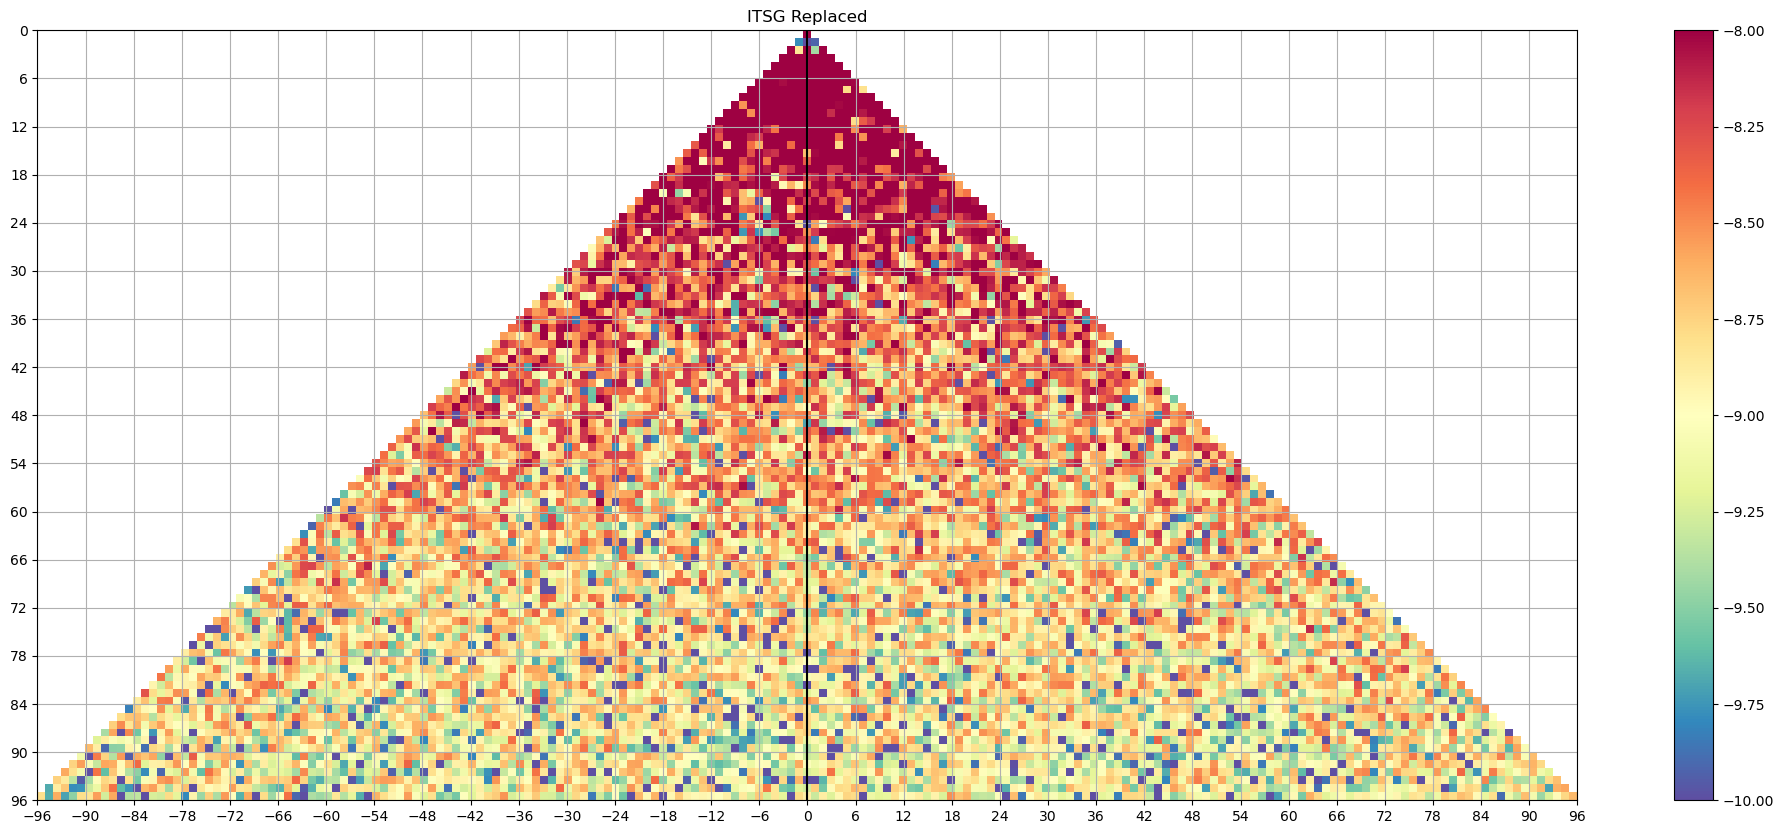

In [10]:
handle = sc_triplot(scmat=rep_sc, lmax=96, title="ITSG Replaced", vmin=-10, vmax=-8)

## CS_Sq_Plot

In [11]:
rep_cs = sc2cs.sc2cs(rep_sc)


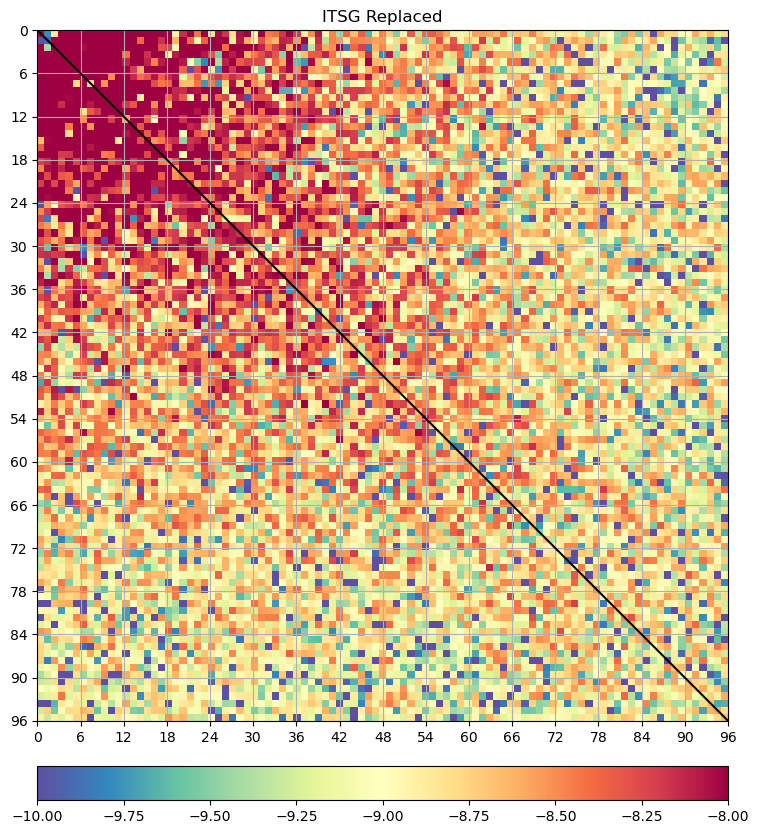

In [15]:
handle = cs_sqplot(csmat=rep_cs, lmax=96, title="ITSG Replaced", vmin=-10, vmax=-8)

## Surface Spherical Harmonics

In [105]:
def ylm(l: int, m: int):
    """_summary_

    Args:
        l (int): Degree
        m (int): Order

    Returns:
        _type_: _description_
    """

    # input handling
    assert l >= 0
    assert abs(m) >= 0
    assert m <= l

    m = abs(m)
    # main code
    thetaRAD  = np.linspace(0,np.pi,37)
    lambdaRAD = np.linspace(0,2*np.pi,73)

    cosml = np.cos(m*lambdaRAD)
    sinml = np.sin(m*lambdaRAD)

    arr = np.zeros((1,1))
    arr[0] = l
    
    p = plm.plm(arr, m, thetaRAD, nargin=1, nargout=1)

    ylmc = p * cosml
    ylms = p * sinml

    return (ylmc, ylms)

In [106]:
def ylm_plot(l: int, m: int):
    ylmc, ylms = ylm(l, m)

    fig = plt.figure(figsize=(15, 7.5))
    ax = plt.axes(projection = ccrs.PlateCarree())

    lons = np.linspace(-180, 180, 73)
    lats = np.linspace(-90, 90, 37)

    x, y = np.meshgrid(lons, lats)

    if m >=0 :
        img_extent = (-180, 180, -90, 90)

        # plot the data
        im = ax.imshow(ylmc[:, 0, :], origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), cmap="Spectral")
    else:
        #plt.contourf(x, y, ylms_00[:, 0, :], cmap='RdYlBu_r')
        im = ax.imshow(ylms[:, 0, :], origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), cmap="Spectral")



    # setting gridlines
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='gray', alpha=0.9, linestyle='--')
    # remove top x label
    gl.top_labels = False
    # change x label styles - font size ad colour
    gl.xlabel_style = {'size':12,}
    # left and right labels
    gl.left_labels = True
    gl.right_labels = False
    # coastlines
    ax.coastlines()

    plt.colorbar(im, orientation='vertical', shrink=0.85, pad=0.02,label=f"[...]")

    plt.title(f"Visualization of Spherical Harmonics - degree: {l} order: {m}")

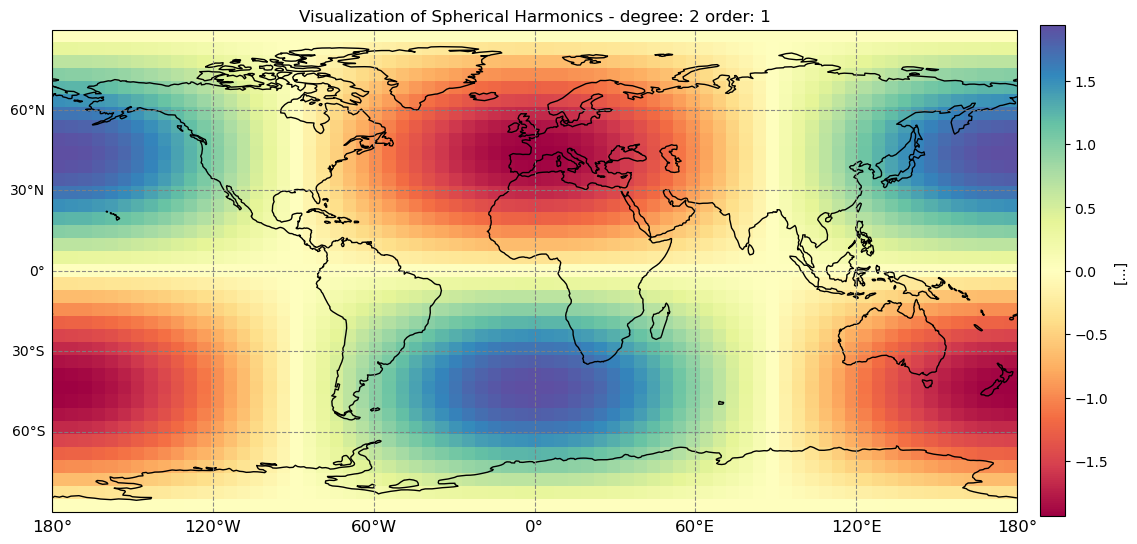

In [111]:
# basic plotting of SH coeff on plane
l = 2
m = 1

ylmc_00, ylms_00 = surface_spherical_hormonics(l=l, m=m)

fig = plt.figure(figsize=(15, 7.5))
ax = plt.axes(projection = ccrs.PlateCarree())

lons = np.linspace(-180, 180, 73)
lats = np.linspace(-90, 90, 37)

x, y = np.meshgrid(lons, lats)
img_extent = (-180, 180, -90, 90)

if m >=0 :
    # plot the data
    im = ax.imshow(ylmc_00[:, 0, :], origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), cmap="Spectral")
else:
    #plt.contourf(x, y, ylms_00[:, 0, :], cmap='RdYlBu_r')
    im = ax.imshow(ylms_00[:, 0, :], origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), cmap="Spectral")



# setting gridlines
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='gray', alpha=0.9, linestyle='--')
# remove top x label
gl.top_labels = False
# change x label styles - font size ad colour
gl.xlabel_style = {'size':12,}
# left and right labels
gl.left_labels = True
gl.right_labels = False
# coastlines
ax.coastlines()

plt.colorbar(im, orientation='vertical', shrink=0.85, pad=0.02,label=f"[...]")

plt.title(f"Visualization of Spherical Harmonics - degree: {l} order: {m}")
plt.show()


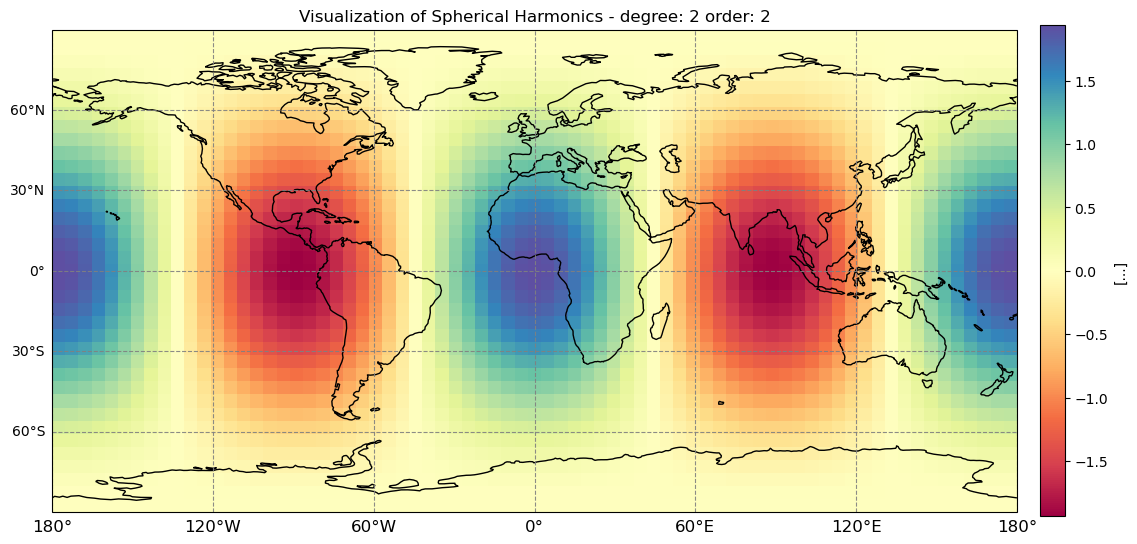

In [117]:
ylm_plot(l=2, m=2)

## Gravity Field

In [14]:
# load long term mean
long_mean_itsg = 'D:\\open_source\\pyshbundle\\pyshbundle\\data\\long_mean\\SH_long_mean_itsg.npy'
SH_long_mean_itsg = np.load(long_mean_itsg)

import pyshbundle.normalklm
normal_cs = pyshbundle.normalklm.normalklm(lmax=96, typ='grs80')

# convert the format 
normal_sc = pyshbundle.cs2sc.cs2sc(normal_cs)


In [15]:
import pyshbundle.gaussian

W = pyshbundle.gaussian.gaussian(L=96, cap=500)

In [88]:
# basic computation

lmax = 96
# grid size
gs = 2.5
quant = 'gravity' 
grd = 'cell'
n = int(180/gs) 
h = 0 
jflag = 0

grid_y = int(180/gs)
grid_x = int(360/gs)

sub_sc = rep_sc - SH_long_mean_itsg
# filtered SH Coeff
shfil = np.zeros([lmax+1, 2 * lmax+1])

# applying filter on substracted coeff
for j in range(0,2*lmax+1, 1):
    shfil[:,j] = W[:,0] * sub_sc[:,j]


flt_ff = pyshbundle.gshs.gshs(shfil, quant, grd, n, h, jflag)[0]

# Computing
grav_field_flt = np.zeros([grid_y,grid_x], dtype ='longdouble')


grav_field_flt[:,0:int(grid_x/2)] = flt_ff[:,int(grid_x/2):]
grav_field_flt[:,int(grid_x/2):] = flt_ff[:,0:int(grid_x/2)]  

In [152]:
def mapfield(field, img_extent, title, name=None, save_flag=False):
    # Plotting and Visualization

    fig = plt.figure(figsize=(16, 7.5))
    geo_ax = plt.axes(projection = ccrs.Robinson())
    # plot the data
    im = geo_ax.imshow(field, origin='upper', extent=img_extent, cmap='RdYlBu', transform=ccrs.PlateCarree(), vmin=-0.011, vmax=0.011)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    # setting gridlines
    gl = geo_ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='gray', alpha=0.9, linestyle='--')
    # remove top x label
    gl.top_labels = False
    # change x label styles - font size ad colour
    gl.xlabel_style = {'size':12,}
    # left and right labels
    gl.left_labels = True
    gl.right_labels = False
    # coastlines
    geo_ax.coastlines()

    # Using new axes for colorbar
    

    plt.colorbar(im, shrink=0.845, orientation='vertical', pad=0.02,label=f"gravity [...]",)

    plt.title(f"Title - {title}")
    if save_flag:
        plt.savefig(f"{name}.jpg")
    
    return fig, geo_ax

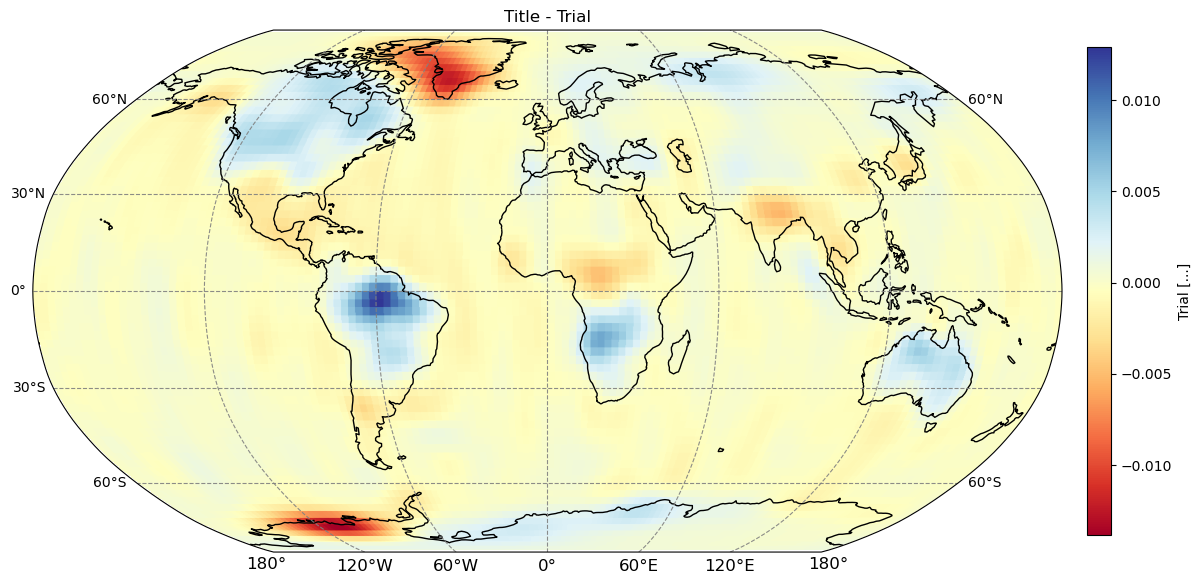

In [84]:
mapfield(field=grav_field_flt, img_extent=(-180, 180, -90, 90))

## Polar Plots

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt

In [102]:
def polar_plot(field, polar_loc: str, title, file_name=None, save_flag=False):

    if polar_loc == 'greenland':
        extent = (-75, -5, 55, 85)

        # setting the 
        fig = plt.figure()
        ax = plt.axes(projection=ccrs.LambertConformal(central_latitude=72,central_longitude=-42.0))

        im = ax.imshow(field, origin='upper', cmap='Spectral', transform=ccrs.PlateCarree(), )

        ax.set_extent((-75, -5, 55, 85))
        gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='gray', alpha=0.9, linestyle='--')

        gl.top_labels = False
        ax.coastlines()
        plt.colorbar(im, orientation='vertical', shrink=1.0, pad=0.1,label=f"[...]")

        plt.title(f"{title}")
        if save_flag:
            plt.savefig(f"{file_name}.jpg")

    
    elif polar_loc == 'antarctica':
        extent = [-180, 180, -85, -60]

        fig = plt.figure(1, figsize=(7, 7))
        # setting the projection for polar plot
        ax = plt.axes(projection=ccrs.SouthPolarStereo())

        # plotting the matrix field
        im = ax.imshow(field, origin='upper', cmap='RdYlBu', transform=ccrs.PlateCarree(),)

        # setting the gridlines and continental boundary
        ax.set_extent(extent, ccrs.PlateCarree())
        gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='gray', alpha=0.9, linestyle='--')
        #gl.top_labels = False
        
        ax.coastlines()

        # to plot the circular plot boundary
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        plt.colorbar(im, orientation='vertical', shrink=1.0, pad=0.1,label=f"[...]")
        plt.title(f"{title}")

        if save_flag:
            plt.savefig(f"{file_name}.jpg")
    return im


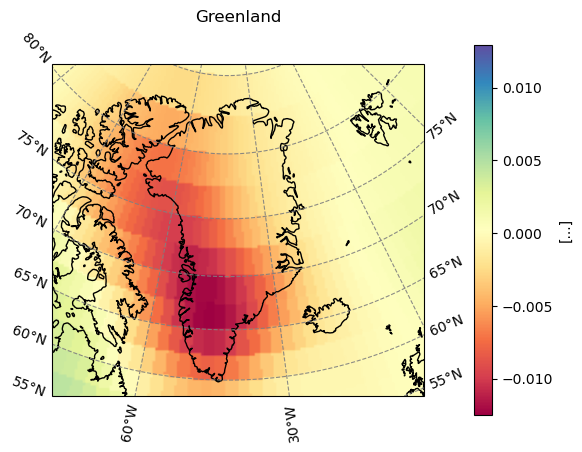

In [103]:
polar_plot(field=grav_field_flt, polar_loc="greenland", title="Greenland", file_name="greenland", save_flag=False)

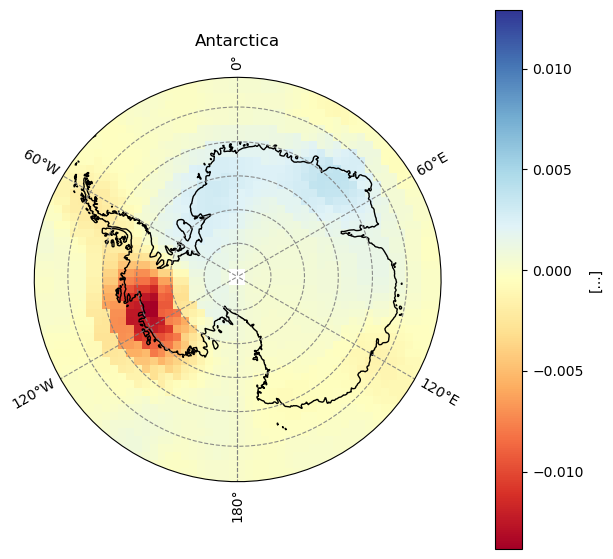

In [104]:
polar_plot(field=grav_field_flt, polar_loc="antarctica", title="Antarctica")

## Time Lapse of Temporal Gravity Variations

In [87]:
# load temporal data
def last_4chars(x):
        #print(x[-39:-32])
        return(x[-11:-4])

In [85]:
tn14_path_itsg = 'D:\open_source\pyshbundle\pyshbundle\data\ITSG_TN_files\TN-14_C30_C20_SLR_GSFC.txt'
tn_13_path_itsg = 'D:\open_source\pyshbundle\pyshbundle\data\ITSG_TN_files\TN-13_GEOC_CSR_RL06.1.txt'
itsg_folder = 'D:\open_source\pyshbundle\sample_input_data\ITSG_input'

In [101]:
# load all the itsg files
files = os.listdir(itsg_folder)
files = sorted(files, key = last_4chars)

data_itsg_mat = np.ndarray((len(files), 4753, 6))
dates_itsg = []
for i in trange(len(files)):
    file_path = itsg_folder + '\\' + files[i]
    header = read_itsg(file_path)[0]
    data_itsg_mat[i, :, :] = read_itsg(file_path)[1]
    dates_itsg.append(read_itsg(file_path)[2])

100%|██████████| 214/214 [00:22<00:00,  9.52it/s]


In [89]:
data_tn13_itsg = read_tn13(tn_13_path_itsg)
data_tn14_itsg = read_tn14(tn14_path_itsg)

In [90]:
#replace_zonal_coeff(data_mat, data_tn13, data_tn14, epoch_begin, epoch_end)
# Replace zonal coeff
replaced_data_mat_itsg = np.ndarray((len(files), 4753, 6))

unreplaced_idx = set()
for i in trange(len(files)):
    try:
        replaced_data_mat_itsg[i, :, :] = replace_zonal_coeff(data_itsg_mat[i, :, :], 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg[i], epoch_end=None)
        print("\n")
    except IndexError:
        print(f"Replacement data for File Index {i} - {dates_itsg[i]} could not be found.... procedding to next file")
        unreplaced_idx.add(i)

unreplaced_idx = list(unreplaced_idx)

  3%|▎         | 6/214 [00:00<00:03, 57.10it/s]

Data Date - 2002-04-01, replacemnt date(tn-13) = 2002-04-05
Data Date - 2002-04-01, replacemnt date(tn-13) = 2002-04-05
[1.00000000e+00 0.00000000e+00 5.21793863e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  2.86777277e-10 -6.80704629e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2002-04-01, replacemnt date (tn-14)_ = 2002-04-04
Data Date - 2002-04-01, replacemnt date (tn-14)_ = 2002-04-04


Data Date - 2002-05-01, replacemnt date(tn-13) = 2002-05-03
Data Date - 2002-05-01, replacemnt date(tn-13) = 2002-05-03
[1.00000000e+00 0.00000000e+00 4.69850864e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.53669799e-10 -8.90896621e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2002-05-01, replacemnt date (tn-14)_ = 2002-05-02
Data Date - 2002-05-01, replacemnt date (tn-14)_ = 2002-05-02


Data Date - 2002-08-01, replacemnt date(tn-13) = 2002-08-01
Data Date - 2002-08-01, replacemnt date(tn-13) = 2002-08-01
[1.0

  9%|▉         | 20/214 [00:00<00:03, 49.91it/s]



Data Date - 2003-08-01, replacemnt date(tn-13) = 2003-08-01
Data Date - 2003-08-01, replacemnt date(tn-13) = 2003-08-01
[ 1.00000000e+00  0.00000000e+00 -8.48334144e-11  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [1.00000000e+00 1.00000000e+00 8.99940877e-12 1.56049408e-10
 4.52960000e-11 5.07240000e-11]
Data Date - 2003-08-01, replacemnt date (tn-14)_ = 2003-08-01
Data Date - 2003-08-01, replacemnt date (tn-14)_ = 2003-08-01


Data Date - 2003-09-01, replacemnt date(tn-13) = 2003-09-01
Data Date - 2003-09-01, replacemnt date(tn-13) = 2003-09-01
[ 1.00000000e+00  0.00000000e+00 -2.43125092e-11  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -4.72783187e-11  2.86422145e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2003-09-01, replacemnt date (tn-14)_ = 2003-09-01
Data Date - 2003-09-01, replacemnt date (tn-14)_ = 2003-09-01


Data Date - 2003-10-01, replacemnt date(tn-13) = 2003-10-01
Data Date - 2003-10-01, replacemnt date(tn-13) = 2003-10

 16%|█▌        | 34/214 [00:00<00:03, 58.21it/s]

Data Date - 2004-04-01, replacemnt date (tn-14)_ = 2004-04-01


Data Date - 2004-05-01, replacemnt date(tn-13) = 2004-05-01
Data Date - 2004-05-01, replacemnt date(tn-13) = 2004-05-01
[1.00000000e+00 0.00000000e+00 3.15484703e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.36781031e-10 -1.37866910e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2004-05-01, replacemnt date (tn-14)_ = 2004-05-01
Data Date - 2004-05-01, replacemnt date (tn-14)_ = 2004-05-01


Data Date - 2004-06-01, replacemnt date(tn-13) = 2004-06-01
Data Date - 2004-06-01, replacemnt date(tn-13) = 2004-06-01
[1.00000000e+00 0.00000000e+00 2.46855161e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  3.04478673e-11 -1.01019658e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2004-06-01, replacemnt date (tn-14)_ = 2004-06-01
Data Date - 2004-06-01, replacemnt date (tn-14)_ = 2004-06-01


Data Date - 2004-07-01, replacemnt date(tn-13) = 2004-07-01


 23%|██▎       | 49/214 [00:00<00:02, 65.24it/s]

Data Date - 2005-05-01, replacemnt date(tn-13) = 2005-05-01
Data Date - 2005-05-01, replacemnt date(tn-13) = 2005-05-01
[1.00000000e+00 0.00000000e+00 4.94511281e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.39493780e-10 -1.44590669e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2005-05-01, replacemnt date (tn-14)_ = 2005-05-01
Data Date - 2005-05-01, replacemnt date (tn-14)_ = 2005-05-01


Data Date - 2005-06-01, replacemnt date(tn-13) = 2005-06-01
Data Date - 2005-06-01, replacemnt date(tn-13) = 2005-06-01
[1.00000000e+00 0.00000000e+00 2.62252382e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  2.79153188e-11 -1.52093718e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2005-06-01, replacemnt date (tn-14)_ = 2005-06-01
Data Date - 2005-06-01, replacemnt date (tn-14)_ = 2005-06-01


Data Date - 2005-07-01, replacemnt date(tn-13) = 2005-07-01
Data Date - 2005-07-01, replacemnt date(tn-13) = 2005-07-01
[1.0

 27%|██▋       | 57/214 [00:00<00:02, 66.64it/s]

Data Date - 2006-08-01, replacemnt date(tn-13) = 2006-08-01
Data Date - 2006-08-01, replacemnt date(tn-13) = 2006-08-01
[ 1.00000000e+00  0.00000000e+00 -1.70613341e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -6.72150275e-11  7.19091524e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2006-08-01, replacemnt date (tn-14)_ = 2006-08-01
Data Date - 2006-08-01, replacemnt date (tn-14)_ = 2006-08-01


Data Date - 2006-09-01, replacemnt date(tn-13) = 2006-09-01
Data Date - 2006-09-01, replacemnt date(tn-13) = 2006-09-01
[ 1.00000000e+00  0.00000000e+00 -1.69548351e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.26643939e-10  2.17649003e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2006-09-01, replacemnt date (tn-14)_ = 2006-09-01
Data Date - 2006-09-01, replacemnt date (tn-14)_ = 2006-09-01


Data Date - 2006-10-01, replacemnt date(tn-13) = 2006-10-01
Data Date - 2006-10-01, replacemnt date(tn-13) = 200

 34%|███▎      | 72/214 [00:01<00:02, 67.45it/s]



Data Date - 2007-12-01, replacemnt date(tn-13) = 2007-12-01
Data Date - 2007-12-01, replacemnt date(tn-13) = 2007-12-01
[1.00000000e+00 0.00000000e+00 9.06389912e-12 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.00955673e-12  6.18750036e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2007-12-01, replacemnt date (tn-14)_ = 2007-12-01
Data Date - 2007-12-01, replacemnt date (tn-14)_ = 2007-12-01


Data Date - 2008-01-01, replacemnt date(tn-13) = 2008-01-01
Data Date - 2008-01-01, replacemnt date(tn-13) = 2008-01-01
[1.00000000e+00 0.00000000e+00 7.40808781e-11 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.54565650e-12  8.07393853e-12
  4.52960000e-11  5.07240000e-11]
Data Date - 2008-01-01, replacemnt date (tn-14)_ = 2008-01-01
Data Date - 2008-01-01, replacemnt date (tn-14)_ = 2008-01-01


Data Date - 2008-02-01, replacemnt date(tn-13) = 2008-02-01
Data Date - 2008-02-01, replacemnt date(tn-13) = 2008-02-01
[1

 41%|████      | 88/214 [00:01<00:01, 71.43it/s]



Data Date - 2009-03-01, replacemnt date(tn-13) = 2009-03-01
Data Date - 2009-03-01, replacemnt date(tn-13) = 2009-03-01
[1.00000000e+00 0.00000000e+00 1.38527684e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.70602971e-10 -1.04010593e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2009-03-01, replacemnt date (tn-14)_ = 2009-03-01
Data Date - 2009-03-01, replacemnt date (tn-14)_ = 2009-03-01


Data Date - 2009-04-01, replacemnt date(tn-13) = 2009-04-01
Data Date - 2009-04-01, replacemnt date(tn-13) = 2009-04-01
[1.00000000e+00 0.00000000e+00 1.88392531e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.96087507e-10 -1.83064385e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2009-04-01, replacemnt date (tn-14)_ = 2009-04-01
Data Date - 2009-04-01, replacemnt date (tn-14)_ = 2009-04-01


Data Date - 2009-05-01, replacemnt date(tn-13) = 2009-05-01
Data Date - 2009-05-01, replacemnt date(tn-13) = 2009-05-01
[1

 49%|████▊     | 104/214 [00:01<00:01, 71.79it/s]



Data Date - 2010-07-01, replacemnt date(tn-13) = 2010-07-01
Data Date - 2010-07-01, replacemnt date(tn-13) = 2010-07-01
[ 1.00000000e+00  0.00000000e+00 -2.39272394e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -2.82738373e-11 -6.87589959e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2010-07-01, replacemnt date (tn-14)_ = 2010-07-01
Data Date - 2010-07-01, replacemnt date (tn-14)_ = 2010-07-01


Data Date - 2010-08-01, replacemnt date(tn-13) = 2010-08-01
Data Date - 2010-08-01, replacemnt date(tn-13) = 2010-08-01
[ 1.00000000e+00  0.00000000e+00 -3.62978637e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.05520599e-10  7.46887789e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2010-08-01, replacemnt date (tn-14)_ = 2010-08-01
Data Date - 2010-08-01, replacemnt date (tn-14)_ = 2010-08-01


Data Date - 2010-09-01, replacemnt date(tn-13) = 2010-09-01
Data Date - 2010-09-01, replacemnt date(tn-13) = 2

 56%|█████▌    | 120/214 [00:01<00:01, 71.61it/s]



Data Date - 2011-12-01, replacemnt date(tn-13) = 2011-12-13
Data Date - 2011-12-01, replacemnt date(tn-13) = 2011-12-13
[ 1.00000000e+00  0.00000000e+00 -2.52738664e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -9.57423681e-11  1.03923490e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2011-12-01, replacemnt date (tn-14)_ = 2011-12-17
Data Date - 2011-12-01, replacemnt date (tn-14)_ = 2011-12-17


Data Date - 2012-01-01, replacemnt date(tn-13) = 2011-12-13
Data Date - 2012-01-01, replacemnt date(tn-13) = 2011-12-13
Data Date - 2012-01-01, replacemnt date(tn-13) = 2012-01-01
Data Date - 2012-01-01, replacemnt date(tn-13) = 2012-01-01
[ 1.00000000e+00  0.00000000e+00 -2.42906929e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -5.29055601e-11  7.24993593e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2012-01-01, replacemnt date (tn-14)_ = 2011-12-17
Data Date - 2012-01-01, replacemnt date (tn-14)_ = 201

 64%|██████▎   | 136/214 [00:02<00:01, 65.49it/s]



Data Date - 2013-10-01, replacemnt date(tn-13) = 2013-10-01
Data Date - 2013-10-01, replacemnt date(tn-13) = 2013-10-01
[ 1.00000000e+00  0.00000000e+00 -4.90844092e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.96637275e-10  2.19057687e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2013-10-01, replacemnt date (tn-14)_ = 2013-10-01
Data Date - 2013-10-01, replacemnt date (tn-14)_ = 2013-10-01


Data Date - 2013-11-01, replacemnt date(tn-13) = 2013-11-01
Data Date - 2013-11-01, replacemnt date(tn-13) = 2013-11-01
[ 1.00000000e+00  0.00000000e+00 -4.07250206e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -2.09803473e-10  1.97653753e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2013-11-01, replacemnt date (tn-14)_ = 2013-11-01
Data Date - 2013-11-01, replacemnt date (tn-14)_ = 2013-11-01


Data Date - 2013-12-01, replacemnt date(tn-13) = 2013-12-01
Data Date - 2013-12-01, replacemnt date(tn-13) = 2

 71%|███████   | 151/214 [00:02<00:00, 68.37it/s]



Data Date - 2015-01-01, replacemnt date(tn-13) = 2015-01-13
Data Date - 2015-01-01, replacemnt date(tn-13) = 2015-01-13
[ 1.00000000e+00  0.00000000e+00 -3.30739962e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -9.73299696e-11  9.92501049e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2015-01-01, replacemnt date (tn-14)_ = 2015-01-13
Data Date - 2015-01-01, replacemnt date (tn-14)_ = 2015-01-13


Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-01-13
Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-01-13
Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-02-01
Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-02-01
[ 1.00000000e+00  0.00000000e+00 -3.30739962e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -9.73299696e-11  9.92501049e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2015-02-01, replacemnt date (tn-14)_ = 2015-01-13
Data Date - 2015-02-01, replacemnt date (tn-14)_ = 201

 78%|███████▊  | 166/214 [00:02<00:00, 68.91it/s]



Data Date - 2016-11-01, replacemnt date(tn-13) = 2016-11-14
Data Date - 2016-11-01, replacemnt date(tn-13) = 2016-11-14
[ 1.00000000e+00  0.00000000e+00 -4.82038618e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -3.53639326e-10  2.05279423e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2016-11-01, replacemnt date (tn-14)_ = 2016-11-14
Data Date - 2016-11-01, replacemnt date (tn-14)_ = 2016-11-14


Data Date - 2016-12-01, replacemnt date(tn-13) = 2016-11-14
Data Date - 2016-12-01, replacemnt date(tn-13) = 2016-11-14
Data Date - 2016-12-01, replacemnt date(tn-13) = 2016-12-11
Data Date - 2016-12-01, replacemnt date(tn-13) = 2016-12-11
[ 1.00000000e+00  0.00000000e+00 -4.82038618e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -3.53639326e-10  2.05279423e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2016-12-01, replacemnt date (tn-14)_ = 2016-11-14
Data Date - 2016-12-01, replacemnt date (tn-14)_ = 201

 84%|████████▍ | 180/214 [00:02<00:00, 68.11it/s]



Data Date - 2019-03-01, replacemnt date(tn-13) = 2019-03-01
Data Date - 2019-03-01, replacemnt date(tn-13) = 2019-03-01
[ 1.00000000e+00  0.00000000e+00 -3.61374585e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -9.59276571e-11 -7.10942594e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2019-03-01, replacemnt date (tn-14)_ = 2019-03-01
Data Date - 2019-03-01, replacemnt date (tn-14)_ = 2019-03-01


Data Date - 2019-04-01, replacemnt date(tn-13) = 2019-04-01
Data Date - 2019-04-01, replacemnt date(tn-13) = 2019-04-01
[ 1.00000000e+00  0.00000000e+00 -3.02333545e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -3.77253991e-11 -1.28280250e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2019-04-01, replacemnt date (tn-14)_ = 2019-04-01
Data Date - 2019-04-01, replacemnt date (tn-14)_ = 2019-04-01


Data Date - 2019-05-01, replacemnt date(tn-13) = 2019-05-01
Data Date - 2019-05-01, replacemnt date(tn-13) = 2

 91%|█████████ | 194/214 [00:02<00:00, 62.01it/s]

Data Date - 2020-04-01, replacemnt date(tn-13) = 2020-04-01
Data Date - 2020-04-01, replacemnt date(tn-13) = 2020-04-01
[ 1.0000000e+00  0.0000000e+00 -2.2419506e-10  0.0000000e+00
  4.4585000e-11  0.0000000e+00] [1.00000000e+00 1.00000000e+00 8.02682499e-11 4.36815458e-11
 4.52960000e-11 5.07240000e-11]
Data Date - 2020-04-01, replacemnt date (tn-14)_ = 2020-04-01
Data Date - 2020-04-01, replacemnt date (tn-14)_ = 2020-04-01


Data Date - 2020-05-01, replacemnt date(tn-13) = 2020-05-01
Data Date - 2020-05-01, replacemnt date(tn-13) = 2020-05-01
[ 1.00000000e+00  0.00000000e+00 -2.77481256e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  3.01087391e-11 -8.65472694e-12
  4.52960000e-11  5.07240000e-11]
Data Date - 2020-05-01, replacemnt date (tn-14)_ = 2020-05-01
Data Date - 2020-05-01, replacemnt date (tn-14)_ = 2020-05-01


Data Date - 2020-06-01, replacemnt date(tn-13) = 2020-06-01
Data Date - 2020-06-01, replacemnt date(tn-13) = 2020-06-01
[ 1.

 94%|█████████▍| 201/214 [00:03<00:00, 63.29it/s]



Data Date - 2021-06-01, replacemnt date(tn-13) = 2021-06-01
Data Date - 2021-06-01, replacemnt date(tn-13) = 2021-06-01
[ 1.00000000e+00  0.00000000e+00 -5.96193459e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -7.89661535e-11 -9.78554665e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2021-06-01, replacemnt date (tn-14)_ = 2021-06-01
Data Date - 2021-06-01, replacemnt date (tn-14)_ = 2021-06-01


Data Date - 2021-07-01, replacemnt date(tn-13) = 2021-07-01
Data Date - 2021-07-01, replacemnt date(tn-13) = 2021-07-01
[ 1.0000000e+00  0.0000000e+00 -7.3902392e-10  0.0000000e+00
  4.4585000e-11  0.0000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.43723708e-10  2.46901060e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2021-07-01, replacemnt date (tn-14)_ = 2021-07-01
Data Date - 2021-07-01, replacemnt date (tn-14)_ = 2021-07-01


Data Date - 2021-08-01, replacemnt date(tn-13) = 2021-08-01
Data Date - 2021-08-01, replacemnt date(tn-13) = 2021-08

100%|██████████| 214/214 [00:03<00:00, 65.60it/s]



Data Date - 2022-05-01, replacemnt date(tn-13) = 2022-05-01
Data Date - 2022-05-01, replacemnt date(tn-13) = 2022-05-01
[ 1.0000000e+00  0.0000000e+00 -5.3690343e-10  0.0000000e+00
  4.4585000e-11  0.0000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.95719639e-11 -9.21260664e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2022-05-01, replacemnt date (tn-14)_ = 2022-05-01
Data Date - 2022-05-01, replacemnt date (tn-14)_ = 2022-05-01


Data Date - 2022-06-01, replacemnt date(tn-13) = 2022-06-01
Data Date - 2022-06-01, replacemnt date(tn-13) = 2022-06-01
[ 1.0000000e+00  0.0000000e+00 -7.3385713e-10  0.0000000e+00
  4.4585000e-11  0.0000000e+00] [ 1.00000000e+00  1.00000000e+00 -8.47254918e-11 -7.50640106e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2022-06-01, replacemnt date (tn-14)_ = 2022-06-01
Data Date - 2022-06-01, replacemnt date (tn-14)_ = 2022-06-01


Data Date - 2022-07-01, replacemnt date(tn-13) = 2022-07-01
Data Date - 2022-07-01, replacemnt date(tn-13) = 2022-07-01
[ 

In [91]:
scmat_deck_itsg = np.ndarray((len(files), 97, 193))

for i in trange(196):
    if i not in unreplaced_idx:
        scmat_deck_itsg[i, :, :] = clm2sc_new(data_itsg_mat[i], lmax=96)
    
    

100%|██████████| 196/196 [00:00<00:00, 211.15it/s]


In [92]:
from datetime import datetime, timedelta
def STR2DON(str_date, source='itsg'):
    if source == "itsg":
        #print("NOTE: ITSG only provides Year-Month, the Date Object Notation will assume it to be the first day of the corresponding month by default! \n")
        return datetime.strptime(str_date, "%Y-%m").date()
    elif source == "csr":
        return datetime.strptime(str_date, "%Y-%m-%d").date()
    elif source == "jpl":
        return datetime.strptime(str_date, "%Y-%m-%d").date()
    else:
        raise ValueError("Enter a valid data source (Processing Centre). Currently only supported for CSR, JPl and ITSG Processing Centers")

In [115]:
def dates_by_year(date_list: list, source='itsg'):
    if source == 'itsg':
        # accertain the type of list
        if type(date_list[0] == 'str'):
            for i in range(len(date_list)):
                date_list[i] = STR2DON(date_list[i], source='itsg')
        
        else:
            raise ValueError("dates should be a list of strings")
        
        list_of_years = []
        valid_months = set(range(1, 13))
        dates_by_year = {}
        # Group the dates by year
        for idx, date in enumerate(date_list):
            year = date.year
            if year not in dates_by_year:
                dates_by_year[year] = []
            dates_by_year[year].append((date, idx))

        # Print the dates grouped by year
        return dates_by_year



        pass
    elif source == 'csr':
        pass
    elif source == 'jpl':
        pass
    pass

In [109]:
import copy
dates_list = copy.deepcopy(dates_itsg)

In [110]:
yearwise_dates = dates_by_year(date_list=dates_list, source='itsg')

In [116]:
yearwise_idx = []
for months in yearwise_dates[2008]:
    yearwise_idx.append(months[-1])

In [118]:
yearwise_idx

[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]

In [119]:
subset_deck = scmat_deck_itsg[66:78, :, :]

In [133]:
subset_dates = dates_list[66:78]

In [138]:
str(subset_dates[0])

'2008-01-01'

In [ ]:
SH_long_mean_itsg

In [122]:
def filter(rep_sc, mean_field):
    # basic computation

    lmax = 96
    # grid size
    gs = 2.5
    quant = 'gravity' 
    grd = 'cell'
    n = int(180/gs) 
    h = 0 
    jflag = 0

    grid_y = int(180/gs)
    grid_x = int(360/gs)

    sub_sc = rep_sc - mean_field
    # filtered SH Coeff
    shfil = np.zeros([lmax+1, 2 * lmax+1])

    # applying filter on substracted coeff
    for j in range(0,2*lmax+1, 1):
        shfil[:,j] = W[:,0] * sub_sc[:,j]


    flt_ff = pyshbundle.gshs.gshs(shfil, quant, grd, n, h, jflag)[0]

    # Computing
    grav_field_flt = np.zeros([grid_y,grid_x], dtype ='longdouble')


    grav_field_flt[:,0:int(grid_x/2)] = flt_ff[:,int(grid_x/2):]
    grav_field_flt[:,int(grid_x/2):] = flt_ff[:,0:int(grid_x/2)]  

    return grav_field_flt

In [153]:
storage_folder="D:\\open_source\\pyshbundle\\notebooks\\imgs\\time-series-timelapse\\"
def time_series_plot(scmat_deck, mean_field, subset_dates, storage_folder):
    """
    """

    for idx, scmat in enumerate(scmat_deck):

        # filter
        flt_field = filter(rep_sc=scmat, mean_field=mean_field)

        # plot 
        file_name = storage_folder + str(idx)
        title=str(subset_dates[idx])
        fig, geo_ax = mapfield(field=flt_field, title=title, img_extent=(-180, 180, -90, 90), save_flag=True,name=file_name)
        plt.clf()



In [154]:
time_series_plot(scmat_deck=subset_deck, mean_field=SH_long_mean_itsg, subset_dates=subset_dates,storage_folder=storage_folder)

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

<Figure size 1600x750 with 0 Axes>

In [158]:
import PIL

image_frames = []

for month in range(12):
    file_path = storage_folder + str(month) + ".jpg"
    new_frame = PIL.Image.open(file_path)
    image_frames.append(new_frame)



In [165]:
image_frames[0].save("D:\\open_source\\pyshbundle\\notebooks\\imgs\\time-series-timelapse\\gravity_timelapse.gif", format='GIF', append_images=image_frames[1:],
save_all=True, duration=500, loop=5)